In [ ]:
pip install tensorflow==1.13.2

     |████████████████████████████████| 92.6MB 60kB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 3.2MB 41.8MB/s 
     |████████████████████████████████| 368kB 39.3MB/s 
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [21]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [22]:
from stable_baselines.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2, A2C, ACKTR
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import results_plotter

In [23]:
class NoisedObservationWrapper(gym.ObservationWrapper):
    # encapsulate environment with this wrapper and use env just like before:
    # env = NoisedObservationWrapper(gym.make("CartPole-v0"))
    # for PPO2:
    # from stable_baselines.common import make_vec_env
    # env = make_vec_env(NoisedObservationWrapper(gym.make("CartPole-v0")))
    
    def __init__(self, env, std_dev=0.1, mean=0):
        super(NoisedObservationWrapper, self).__init__(env)
        self.std_dev = std_dev
        self.mean = mean
      
    def observation(self, observation):
        # Modify observation here, e.g. just add noise at certain angles etc.
        # for now we add noise with mu=0 and std=0.1 on all observations
        return observation + np.random.normal(self.mean, self.std_dev, 4)


def sample_data(env, episodes=200, save=False):
    env.np_random.seed(0)

    CART_POS="cartPos"
    CART_VEL="cartVel"
    PEND_POS="pendPos"
    PEND_VEL="pendVel"
    EPISODE="episode"
    STEP="step"
    ACTION="action"

    # create empty Pandas dataset
    d = {
        CART_POS:[], CART_VEL:[], 
        PEND_POS:[], PEND_VEL:[],
        EPISODE:[], STEP:[], ACTION:[]
        }
    df = pd.DataFrame(data=d)

    # sample data
    for episode in range(episodes):
        print ("Start of episode %d" % episode)
        obs = env.reset()
        step = 0
        done = False
        
        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()
            
            df = df.append ({CART_POS:obs[0], CART_VEL:obs[1], 
                            PEND_POS:obs[2], PEND_VEL:obs[3],
                            EPISODE:episode, STEP:step, ACTION:action}, ignore_index=True)
            
            obs, reward, done, _ = env.step(action)
    
    if save:
        store = pd.HDFStore('sample_data.h5')
        store['df'] = df
    
    return df

In [24]:
log_dir1 = "logs1"
log_dir2 = "logs2"
os.makedirs(log_dir1, exist_ok=True)
os.makedirs(log_dir2, exist_ok=True)

In [25]:
env1 = gym.make('CartPole-v1')
env1 = Monitor(env1, log_dir1) # required for using callback functions during training

In [26]:
env2 = NoisedObservationWrapper(gym.make("CartPole-v0"))
env2 = Monitor(env2, log_dir2) # required for using callback functions during training

In [27]:
from stable_baselines.common.callbacks import BaseCallback
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param avg_episodes: (int) average over the past n episodes (default: 100)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    :param vec_norm_env: (VecNormalize) stable-baselines VecNormalize object (contains Gym env)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1, avg_episodes=100, vec_norm_env=None):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model_nn')
        self.best_mean_reward = -np.inf
        self.best_timestep = -np.inf
        self.vec_norm_env = vec_norm_env
        self.avg_episodes = avg_episodes

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            
            if len(x) > 0:
                # Mean training reward over the last avg_episodes episodes
                mean_reward = np.mean(y[-self.avg_episodes:])

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    self.best_timestep = self.num_timesteps
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                    self.model.save(self.save_path)

                if self.verbose > 0:
                    print("Num timesteps: {}".format(self.num_timesteps))
                    print("Best mean reward: {:.2f} (ts={}) - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, self.best_timestep, mean_reward))


        return True

In [32]:
time_steps=21000

tensorboard_dir1 = "cartpole1"
os.makedirs(tensorboard_dir1, exist_ok=True)
model1 = PPO2(MlpPolicy, env1, verbose=0)
callback1=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir1, avg_episodes=30, vec_norm_env=env1)
model1.learn(total_timesteps=time_steps, callback=callback1)

Saving new best model to logs1/best_model_nn
Num timesteps: 5000
Best mean reward: 87.67 (ts=5000) - Last mean reward per episode: 87.67
Saving new best model to logs1/best_model_nn
Num timesteps: 10000
Best mean reward: 137.77 (ts=10000) - Last mean reward per episode: 137.77
Saving new best model to logs1/best_model_nn
Num timesteps: 15000
Best mean reward: 145.77 (ts=15000) - Last mean reward per episode: 145.77
Saving new best model to logs1/best_model_nn
Num timesteps: 20000
Best mean reward: 205.20 (ts=20000) - Last mean reward per episode: 205.20


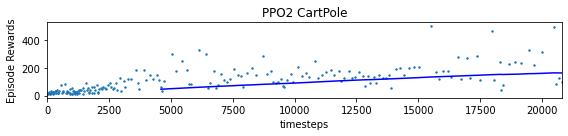

In [33]:
results_plotter.plot_results([log_dir1], time_steps, results_plotter.X_TIMESTEPS, "PPO2 CartPole")
plt.savefig("results1-cartpole.png")
plt.show()

In [34]:
tensorboard_dir2 = "cartpole2"
os.makedirs(tensorboard_dir2, exist_ok=True)
model2 = PPO2(MlpPolicy, env2, verbose=0)
callback2=SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir2, avg_episodes=30, vec_norm_env=env2)
model2.learn(total_timesteps=time_steps, callback=callback2)

Saving new best model to logs2/best_model_nn
Num timesteps: 5000
Best mean reward: 76.47 (ts=5000) - Last mean reward per episode: 76.47
Saving new best model to logs2/best_model_nn
Num timesteps: 10000
Best mean reward: 128.87 (ts=10000) - Last mean reward per episode: 128.87
Saving new best model to logs2/best_model_nn
Num timesteps: 15000
Best mean reward: 142.90 (ts=15000) - Last mean reward per episode: 142.90
Saving new best model to logs2/best_model_nn
Num timesteps: 20000
Best mean reward: 170.27 (ts=20000) - Last mean reward per episode: 170.27


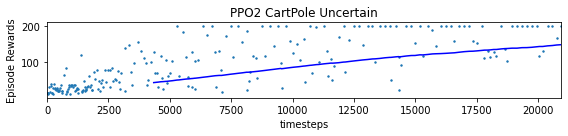

In [35]:
results_plotter.plot_results([log_dir2], time_steps, results_plotter.X_TIMESTEPS, "PPO2 CartPole Uncertain")
plt.savefig("results2-cartpole.png")
plt.show()